In [1]:
# system imports
import sys
import os
os.environ['DISPLAY'] = '0'
import datetime
import shutil
import atexit
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import matplotlib
if "DISPLAY" not in os.environ:
    matplotlib.use("Agg")

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pickle
import dill
from copy import deepcopy
from datetime import timedelta, datetime

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, plot_reflux_distribution,\
                                    plot_distribution, plot_product_distribution, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_iteration, tray_translator
from utility.model_utility import which_MPCC, select_MPCC, augmented_objective, add_solver, disable_restoration
from utility.time_utility import create_filename_time, log_now, log_end

class data_object(object):
    def __init__(self, name):
        self.name = name

2018-10-20 00:49:05 - Start Program


In [2]:
with open('./log/model/Preset_Case_317_pf.pickle','rb') as f:
    model = dill.load(f)
# with open('./log/model/Preset_Case_3_pf.pickle','rb') as f:
#     model = dill.load(f)

In [3]:
opt = add_solver(pe,max_iter=1000,warm_start=True)

In [4]:
model.economic = pe.Var(within=pe.Reals)
model.tunneling_equation = pe.ConstraintList()
model.tunneling_equation.add(model.economic == 
                             43*model.P_total['naphtha']\
                            +20*model.P_total['intermediate']\
                            +90*model.P_total['gasoline']\
                            +128*model.P_total['diesel']\
                            +100*model.P_total['heavy']\
                            +1.3*model.condenser.V['P']\
                            -2.24*model.total_feed\
                            +0.005*(model.N_reflux_tray-1)
);

In [5]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.economic, sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> economic - reactive[1].MPCC_P_pf.pf - reactive[2].MPCC_P_pf.pf - reactive[3].MPCC_P_pf.pf - reactive[4].MPCC_P_pf.pf - reactive[5].MPCC_P_pf.pf - reactive[6].MPCC_P_pf.pf - reactive[7].MPCC_P_pf.pf - reactive[8].MPCC_P_pf.pf - reactive[9].MPCC_P_pf.pf - reactive[10].MPCC_P_pf.pf - reactive[11].MPCC_P_pf.pf - reactive[12].MPCC_P_pf.pf - reactive[13].MPCC_P_pf.pf - reactive[14].MPCC_P_pf.pf - reactive[15].MPCC_P_pf.pf - reactive[16].MPCC_P_pf.pf - reactive[17].MPCC_P_pf.pf - reactive[18].MPCC_P_pf.pf - reactive[19].MPCC_P_pf.pf - reactive[20].MPCC_P_pf.pf - reboiler.MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [6]:
results = opt.solve(model,tee=False)
update_dual(pe,model)

# We pick the worst of the worst model from our multi-start study

In [7]:
model.economic.value

2.1560983597838312

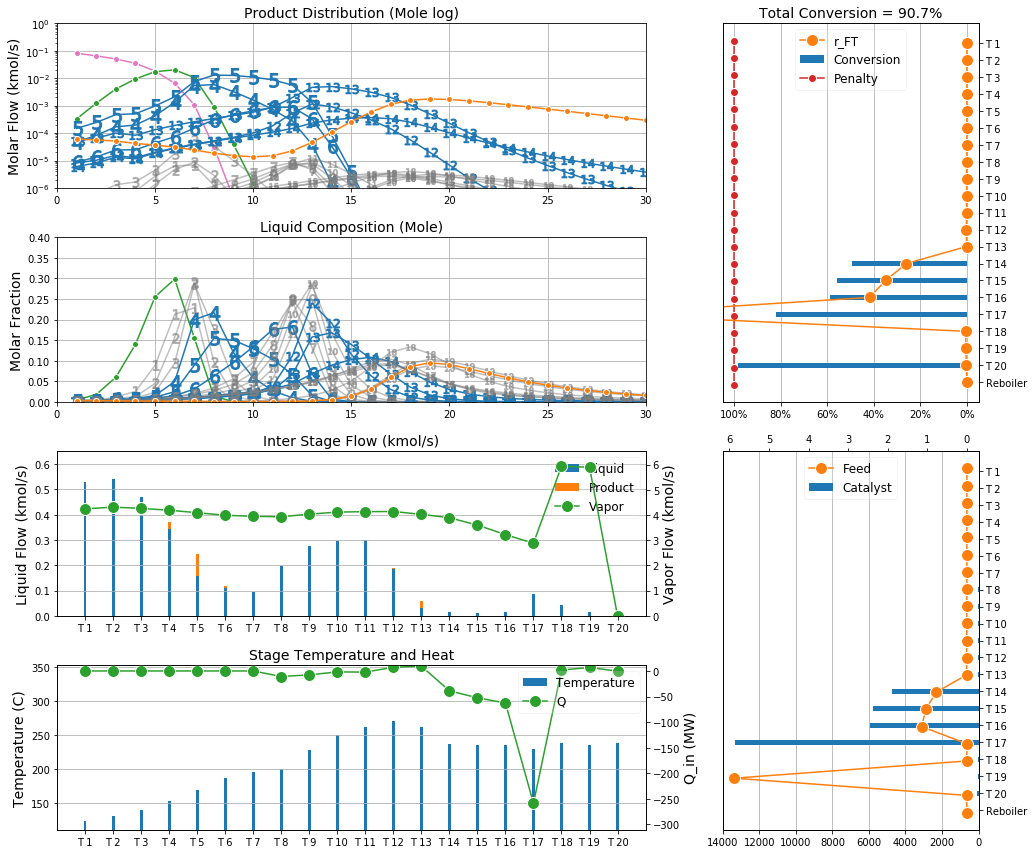

In [8]:
plot_distribution(model)

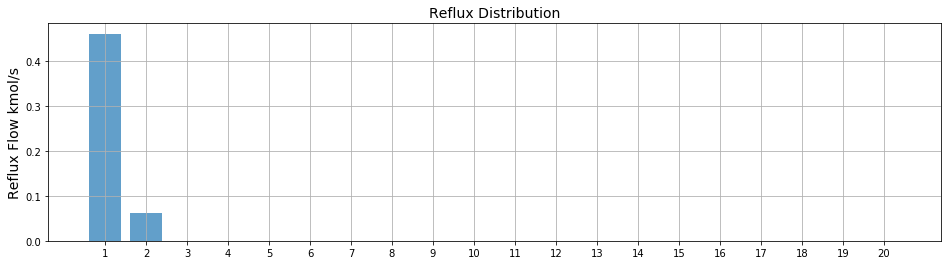

In [9]:
plot_reflux_distribution(model)

# Attempt to find out how much % in what

In [17]:
model.P_total.pprint()

P_total : Size=5, Index=PRODUCT
    Key          : Lower   : Value                : Upper : Fixed : Stale : Domain
          diesel : 0.00022 :  0.03793933872093392 :  None : False : False : NonNegativeReals
        gasoline : 0.00022 :  0.11694374748666163 :  None : False : False : NonNegativeReals
           heavy :       0 : 0.018502723648073646 :  None : False : False : NonNegativeReals
    intermediate : 0.00022 :              0.00022 :  None : False : False : NonNegativeReals
         naphtha :       0 :   0.0677902484347411 :  None : False : False : NonNegativeReals


In [32]:
dic = {}
for i,p in model.x_P:
    if i != 'H2O':
        dic[i,p] = (model.P_total[p].value*model.x_P[i,p].value) \
                    / (sum(model.x_P[i,p_].value*model.P_total[p_].value for p_ in model.P_total) \
                       + model.condenser.V['P'].value * model.condenser.y[i].value)
    else:
        dic[i,p] = (model.P_total[p].value*model.x_P[i,p].value) \
                    / (sum(model.x_P[i,p_].value*model.P_total[p_].value for p_ in model.P_total) \
                       + model.condenser.V['P'].value * model.condenser.y[i].value \
                       + model.condenser.W.value)
        
for i in m.COMP_TOTAL:
    dic[i,'V'] = (model.condenser.V['P'].value * model.condenser.y[i].value) \
                / (sum(model.x_P[i,p_].value*model.P_total[p_].value for p_ in model.P_total) \
                   + model.condenser.V['P'].value * model.condenser.y[i].value)

In [33]:
%store dic

Stored 'dic' (dict)


In [34]:
model.condenser.W.value

2.2247835125245055

In [35]:
2.6 / (model.total_feed.value / 3)

0.8802752175259688